In [1]:
print(">>> [PHẦN 1] Bắt đầu chạy Tiền xử lý Dữ liệu...")

import pandas as pd
import numpy as np
import kagglehub
import os
import sys
import pandas.api.types as ptypes
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Import các công cụ phân tích ---
from sklearn.preprocessing import RobustScaler # <<< DÙNG ROBUSTSCALER
from sklearn.decomposition import PCA

# --- Bỏ qua các cảnh báo (cho gọn) ---
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

>>> [PHẦN 1] Bắt đầu chạy Tiền xử lý Dữ liệu...


In [2]:
print("[Cell] Đang định nghĩa hàm _time_string_to_seconds...")

def _time_string_to_seconds(time_str):
    """Hàm nội bộ: Chuyển đổi 'HH:MM:SS' hoặc 'MM:SS' thành giây."""
    if isinstance(time_str, str):
        parts = time_str.split(':')
        if len(parts) == 3:
            h, m, s = map(int, parts)
            return h * 3600 + m * 60 + s
        elif len(parts) == 2:
            m, s = map(int, parts)
            return m * 60 + s
    return pd.to_numeric(time_str, errors='coerce')

[Cell] Đang định nghĩa hàm _time_string_to_seconds...


In [3]:
# %%
print("[Cell] Đang định nghĩa hàm save_processed_data...")

def save_processed_data(df_to_save, filename='dataset_clean.csv'):
    """
    Lưu DataFrame đã xử lý vào thư mục processed, nằm trong thư mục data của dự án (../data/processed).
    
    :param df_to_save: DataFrame cần lưu (thường là X_pca_df hoặc df_clean).
    :param filename: Tên file CSV đầu ra.
    """
    if df_to_save is None or df_to_save.empty:
        print("LỖI: DataFrame rỗng, không thể lưu.")
        return

    try:
        CURRENT_DIR = os.getcwd() 
        # Lùi lại một cấp từ thư mục hiện tại
        ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, os.pardir))
        # Tạo đường dẫn /data/processed
        PROCESSED_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'processed')

        if not os.path.exists(PROCESSED_DATA_PATH):
            os.makedirs(PROCESSED_DATA_PATH)
            print(f"Đã tạo thư mục: {PROCESSED_DATA_PATH}")

        file_path = os.path.join(PROCESSED_DATA_PATH, filename)
        
        # Lưu file
        df_to_save.to_csv(file_path, index=False)
        print("="*50)
        print(f"LƯU THÀNH CÔNG: Dữ liệu sạch đã được lưu tại:")
        print(f"-> {file_path}")
        print(f"Kích thước DataFrame đã lưu: {df_to_save.shape}")
        print("="*50)

    except Exception as e:
        print(f"LỖI: Không thể lưu file CSV. {e}")

[Cell] Đang định nghĩa hàm save_processed_data...


In [4]:
print("[Cell] Đang định nghĩa hàm load_and_preprocess_data...")

def load_and_preprocess_data():
    """
    Hàm chính: Tải, làm sạch, và chuẩn bị dữ liệu (từ code của bạn).
    Sẽ trả về DataFrame đã làm sạch (chưa scale).
    """
    print("\n" + "="*50)
    print("--- Bắt đầu Giai đoạn 1: Tiền xử lý Dữ liệu (Hồi quy) ---")
    
    try:
        CURRENT_DIR = os.getcwd() 
        ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, os.pardir))
        
        RAW_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'raw')
        # Sửa KAGGLE_DATASET để khớp với code của đồng đội
        KAGGLE_DATASET = "kristhecoder/youtube-revenue-data-20182021" 
        CSV_FILES_TO_LOAD = ['Table-data-2018.csv', 'Table-data-2019.csv', 'Table-data-2020.csv']
        
        print(f"Thư mục gốc của dự án: {ROOT_DIR}")
    except Exception as e:
        print(f"Lỗi khi thiết lập đường dẫn: {e}")
        return None
    
    # --- B. Tải và Gộp (Concat) 3 file CSV ---
    files_to_load = CSV_FILES_TO_LOAD
    df_list = []
    data_folder = RAW_DATA_PATH
    
    print("\nĐang tìm dữ liệu cục bộ...")
    for f_name in files_to_load:
        file_path = os.path.join(data_folder, f_name)
        if os.path.exists(file_path):
            try:
                df_list.append(pd.read_csv(file_path)[1:])
                print(f"Đã tải file: {f_name}")
            except Exception as read_e:
                print(f"LỖI: Không thể đọc file {f_name}. {read_e}")
        else:
             print(f"Cảnh báo: Không tìm thấy file {f_name} tại {file_path}")

    # Kịch bản 3: Tải từ Kaggle (nếu không có file nào)
    if not df_list:
        print("Không tìm thấy file cục bộ. Đang thử tải từ Kaggle...")
        try:
            # Dùng kagglehub.dataset_download như code đồng đội
            data_folder_download = kagglehub.dataset_download(KAGGLE_DATASET, path=RAW_DATA_PATH)
            print(f"Tải từ Kaggle thành công vào: {data_folder_download}")
            # Chạy lại logic đọc file
            for f_name in CSV_FILES_TO_LOAD:
                file_path = os.path.join(data_folder_download, f_name)
                if os.path.exists(file_path):
                    df_list.append(pd.read_csv(file_path)[1:])
                    print(f"Đã tải file: {f_name}")
        except Exception as e:
            print(f"LỖI: Tải từ Kaggle cũng thất bại. {e}")
            return None

    if not df_list:
        print("LỖI: Không đọc được file CSV nào. Dừng chương trình.")
        return None
        
    df = pd.concat(df_list).reset_index(drop=True)
    print("Tải và gộp file thành công.")

    # --- C. Sửa tên cột (Từ code của bạn) ---
    df.columns = df.columns.str.replace(' ', '_')
    col_map = {
        'Av­er­age_views_per_view­er': 'Average_views_per_viewer',
        'Unique_view­ers': 'Unique_viewers',
        'Av­er­age_per­cent­age_viewed_(%)': 'Average_viewed_(%)',
        'Im­pres­sions': 'Impressions', 'Dis\xadlikes': 'Dislikes',
        'Sub­scribers_lost': 'Subscribers_lost', 'Sub­scribers_gained': 'Subscribers_gained',
        'Videos_pub­lished': 'Videos_published', 
        'Videos_ad­ded': 'Videos_added', 
        'Sub­scribers': 'Subscribers_net_change',
        'Im­pres­sions_click-through_rate_(%)': 'Click_rate_(%)',
        'Com­ments_ad­ded': 'Comments', 'Watch_time_(hours)': 'Watch_hours',
        'Av­er­age_view_dur­a­tion': 'Average_view_sec',
        'Your_es­tim­ated_rev­en­ue_(USD)': 'Revenue_(USD)',
        'Likes_(vs._dis­likes)_(%)': 'Likes_vs_Dislikes_(%)',
    }
    # Sửa tên cột đồng đội (Nếu có)
    df = df.rename(columns=col_map) # Chạy col_map của bạn sau
    
    # --- D. Xử lý NaN (Từ code của bạn) ---
    # Bạn fill cả 2 (An toàn hơn)

    # --- E. Chuyển đổi kiểu dữ liệu (Từ code của bạn) ---
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    if 'Average_view_sec' in df.columns and ptypes.is_object_dtype(df['Average_view_sec']):
        print("Phát hiện 'Average_view_sec' là string. Đang chuyển đổi sang giây...")
        df['Average_view_sec'] = df['Average_view_sec'].apply(_time_string_to_seconds)
    
    numeric_cols = df.select_dtypes(include='object').columns.drop('Date', errors='ignore')
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.fillna(0) 

    # --- F. Xử lý giá trị âm (Từ code của bạn) ---
    print("Đang xử lý giá trị âm...")
    cols_to_clip = ['Likes', 'Dislikes', 'Views', 'Impressions', 'Comments', 'Shares', 
                    'Watch_hours', 'Unique_viewers', 'Average_view_sec', 'Revenue_(USD)']
    for col in cols_to_clip:
        if col in df.columns: 
            df[col] = df[col].clip(lower=0) 

    # --- G. Kỹ thuật thuộc tính (Từ code của bạn) ---
    if 'Subscribers_net_change' in df.columns:
        df['Subs_accumulated'] = df['Subscribers_net_change'].cumsum()
    elif 'Subs_accumulated' not in df.columns:
        df['Subs_accumulated'] = 0 

    # --- H. Lựa chọn thuộc tính cuối cùng (Từ code của bạn) ---
    print("Đang lựa chọn thuộc tính cuối cùng...")
    features_to_drop = [
        'Date', # Bỏ Date vì PCA không xử lý được
        'Subscribers_net_change', 
        'Likes_vs_Dislikes_(%)', 
        # Các cột đồng đội bạn đã bỏ:
        'Subscribers_lost',
        'Subscribers_gained'
    ]
    
    cols_to_keep = [col for col in df.columns if col not in features_to_drop and col in df.columns]
    df_clean = df[cols_to_keep]
    
    print(f"Tiền xử lý hoàn tất. Dữ liệu sạch có {df_clean.shape[0]} hàng và {df_clean.shape[1]} cột.")
    print("--- Kết thúc Giai đoạn 1 ---")
    return df_clean

[Cell] Đang định nghĩa hàm load_and_preprocess_data...


In [5]:
df = load_and_preprocess_data()
df.head()
save_processed_data(df)
print("\n>>> [PHẦN 1] Đã chạy xong.")


--- Bắt đầu Giai đoạn 1: Tiền xử lý Dữ liệu (Hồi quy) ---
Thư mục gốc của dự án: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau

Đang tìm dữ liệu cục bộ...


Đã tải file: Table-data-2018.csv
Đã tải file: Table-data-2019.csv
Đã tải file: Table-data-2020.csv
Tải và gộp file thành công.
Phát hiện 'Average_view_sec' là string. Đang chuyển đổi sang giây...
Đang xử lý giá trị âm...
Đang lựa chọn thuộc tính cuối cùng...
Tiền xử lý hoàn tất. Dữ liệu sạch có 1135 hàng và 16 cột.
--- Kết thúc Giai đoạn 1 ---
LƯU THÀNH CÔNG: Dữ liệu sạch đã được lưu tại:
-> c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\data\processed\dataset_clean.csv
Kích thước DataFrame đã lưu: (1135, 16)

>>> [PHẦN 1] Đã chạy xong.


In [17]:
# %%
# ==============================================================================
# === CELL MỚI: SO SÁNH DỮ LIỆU TRƯỚC VÀ SAU KHI TIỀN XỬ LÝ ===
# ==============================================================================
print("\n" + "="*50)
print(">>> [PHẦN SO SÁNH] Lấy 3 record đầu tiên (Trước và Sau khi xử lý)")
print("="*50)

# --- 1. Lấy dữ liệu SAU KHI xử lý (df_clean) ---
# Biến 'df' này đã tồn tại sau khi chạy cell `load_and_preprocess_data()`
if 'df' in locals() and df is not None:
    print("\n🔹 Dữ liệu SAU TIỀN XỬ LÝ (df_clean, chưa RobustScale):")
    display(df.head(3))
    
    # --- 2. Lấy dữ liệu TRƯỚC KHI xử lý (df_raw) ---
    # Phải tải lại file thô, vì biến thô không được lưu
    print("\n🔹 Dữ liệu GỐC (TRƯỚC TIỀN XỬ LÝ):")
    try:
        # TÁI THIẾT LẬP ĐƯỜNG DẪN (Giống như trong hàm load_and_preprocess_data)
        CURRENT_DIR = os.getcwd() 
        ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, os.pardir))
        RAW_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'raw')
        KAGGLE_DATASET_ID = "kristhecoder/youtube-revenue-data-20182021" # Từ code của bạn
        CSV_FILES_TO_LOAD = ['Table-data-2018.csv', 'Table-data-2019.csv', 'Table-data-2020.csv']

        df_list_raw = []
        
        # Giả sử file đã được tải về (vì cell trước đã chạy)
        for f_name in CSV_FILES_TO_LOAD:
            # Đường dẫn 1: Nằm trực tiếp trong /raw
            file_path_1 = os.path.join(RAW_DATA_PATH, f_name)
            # Đường dẫn 2: Nằm trong thư mục con do kagglehub tạo ra
            file_path_2 = os.path.join(RAW_DATA_PATH, KAGGLE_DATASET_ID, f_name)
            
            if os.path.exists(file_path_1):
                # Tải thô, bỏ qua dòng 1 (header_skip) như trong code gốc [1:]
                df_list_raw.append(pd.read_csv(file_path_1)[1:])
            elif os.path.exists(file_path_2):
                # Tải thô từ đường dẫn kagglehub
                 df_list_raw.append(pd.read_csv(file_path_2)[1:])
            else:
                print(f"Cảnh báo: Không tìm thấy file thô {f_name} để so sánh.")

        if df_list_raw:
            # Gộp lại
            df_raw = pd.concat(df_list_raw).reset_index(drop=True)
            print("Tải lại dữ liệu thô để so sánh thành công.")
            display(df_raw.head(3))
        else:
            print("LỖI: Không thể tải lại dữ liệu thô để so sánh (Không tìm thấy file).")
            
    except Exception as e:
        print(f"LỖI khi tải dữ liệu thô để so sánh: {e}")
else:
    print("LỖI: Biến 'df' (dữ liệu đã xử lý) không tồn tại. Hãy chạy cell 'load_and_preprocess_data()' trước.")

print("\n>>> [PHẦN SO SÁNH] Hoàn tất.")
# ==============================================================================
# %%


>>> [PHẦN SO SÁNH] Lấy 3 record đầu tiên (Trước và Sau khi xử lý)

🔹 Dữ liệu SAU TIỀN XỬ LÝ (df_clean, chưa RobustScale):


,Average_views_per_viewer,Unique_viewers,Click_rate_(%),Impressions,Comments,Shares,Dislikes,Likes,Average_viewed_(%),Videos_published,Videos_added,Views,Watch_hours,Average_view_sec,Revenue_(USD),Subs_accumulated
0,1.1538,13.0,7.38,122.0,2.0,1.0,0.0,5.0,53.59,1.0,1.0,15.0,0.4666,111.0,0.0,5.0
1,1.1935,31.0,23.14,121.0,3.0,0.0,0.0,4.0,44.58,0.0,0.0,37.0,0.9575,93.0,0.0,9.0
2,1.3684,19.0,20.65,92.0,1.0,0.0,0.0,5.0,38.75,0.0,0.0,26.0,0.5849,80.0,0.0,11.0



🔹 Dữ liệu GỐC (TRƯỚC TIỀN XỬ LÝ):
Tải lại dữ liệu thô để so sánh thành công.


,Date,Av­er­age views per view­er,Unique view­ers,Im­pres­sions click-through rate (%),Im­pres­sions,Com­ments ad­ded,Shares,Likes (vs. dis­likes) (%),Dis­likes,Sub­scribers lost,Sub­scribers gained,Likes,Av­er­age per­cent­age viewed (%),Videos pub­lished,Videos ad­ded,Sub­scribers,Views,Watch time (hours),Av­er­age view dur­a­tion,Your es­tim­ated rev­en­ue (USD)
0,2018-08-21,1.1538,13.0,7.38,122.0,2.0,1.0,100.0,0.0,0.0,5.0,5.0,53.59,1.0,1.0,5.0,15.0,0.4666,0:01:51,0.0
1,2018-08-22,1.1935,31.0,23.14,121.0,3.0,0.0,100.0,0.0,2.0,6.0,4.0,44.58,NaN,NaN,4.0,37.0,0.9575,0:01:33,0.0
2,2018-08-23,1.3684,19.0,20.65,92.0,1.0,0.0,100.0,0.0,0.0,2.0,5.0,38.75,NaN,NaN,2.0,26.0,0.5849,0:01:20,0.0



>>> [PHẦN SO SÁNH] Hoàn tất.


In [6]:
if df is not None:
    # Phân tách X và y
    target = 'Revenue_(USD)'
    X = df.drop(columns=[target])
    y = df[target]

    print("Kích thước dữ liệu:", df.shape)
    print("\n🔹 Thông tin dữ liệu:")
    print(df.info())
else:
    print("LỖI: DataFrame 'df' rỗng, không thể tiếp tục phân tích.")


Kích thước dữ liệu: (1135, 16)

🔹 Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135 entries, 0 to 1134
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Average_views_per_viewer  1135 non-null   float64
 1   Unique_viewers            1135 non-null   float64
 2   Click_rate_(%)            1135 non-null   float64
 3   Impressions               1135 non-null   float64
 4   Comments                  1135 non-null   float64
 5   Shares                    1135 non-null   float64
 6   Dislikes                  1135 non-null   float64
 7   Likes                     1135 non-null   float64
 8   Average_viewed_(%)        1135 non-null   float64
 9   Videos_published          1135 non-null   float64
 10  Videos_added              1135 non-null   float64
 11  Views                     1135 non-null   float64
 12  Watch_hours               1135 non-null   float64
 13  Average_vi

In [7]:
if df is not None:
    print("🔹 Thống kê mô tả từng cột:")
    display(df.describe().T.round(5))


🔹 Thống kê mô tả từng cột:


,count,mean,std,min,25%,50%,75%,max
Average_views_per_viewer,1135.0,1.62429,3.325100e-01,0.0,1.4258,1.5561,1.79075,2.615800e+00
Unique_viewers,1135.0,25329.78062,5.485316e+04,0.0,455.0000,4052.0000,17816.00000,4.822540e+05
Click_rate_(%),1135.0,6.56063,2.263760e+00,0.0,5.1600,6.1100,7.12500,2.314000e+01
Impressions,1135.0,831357.56300,1.876692e+06,0.0,8445.0000,68704.0000,396741.50000,1.632350e+07
Comments,1135.0,223.52775,7.361278e+02,0.0,2.0000,28.0000,128.00000,1.158200e+04
Shares,1135.0,122.71101,3.335977e+02,0.0,2.0000,22.0000,86.50000,6.513000e+03
Dislikes,1135.0,39.29075,8.141114e+01,0.0,0.0000,6.0000,30.50000,6.640000e+02
Likes,1135.0,2781.47489,7.460127e+03,0.0,14.5000,254.0000,1243.50000,6.354300e+04
Average_viewed_(%),1135.0,28.72157,6.248640e+00,0.0,24.1900,28.0700,32.53000,6.219000e+01
Videos_published,1135.0,0.11013,3.242600e-01,0.0,0.0000,0.0000,0.00000,3.000000e+00


In [8]:
if df is not None:
    print("\n🔹 Phân tích độ lệch và độ nhọn:")
    stats_df = pd.DataFrame({
        'Mean': df.mean(),
        'Std': df.std(),
        'Skewness': df.skew(),
        'Kurtosis': df.kurt()
    }).round(3)
    display(stats_df)
    print(">>> KẾT LUẬN: Skewness và Kurtosis rất cao -> Dữ liệu lệch và có ngoại lai.")


🔹 Phân tích độ lệch và độ nhọn:


,Mean,Std,Skewness,Kurtosis
Average_views_per_viewer,1.624,0.333,0.554,1.187
Unique_viewers,25329.781,54853.156,3.746,17.223
Click_rate_(%),6.561,2.264,2.255,8.758
Impressions,831357.563,1876691.961,3.202,12.244
Comments,223.528,736.128,7.837,82.129
Shares,122.711,333.598,8.735,130.511
Dislikes,39.291,81.411,3.351,13.786
Likes,2781.475,7460.127,4.886,28.761
Average_viewed_(%),28.722,6.249,0.624,2.070
Videos_published,0.110,0.324,2.956,9.654


>>> KẾT LUẬN: Skewness và Kurtosis rất cao -> Dữ liệu lệch và có ngoại lai.



🔹 Trực quan hóa phân phối (Histogram):


<Figure size 1200x800 with 0 Axes>

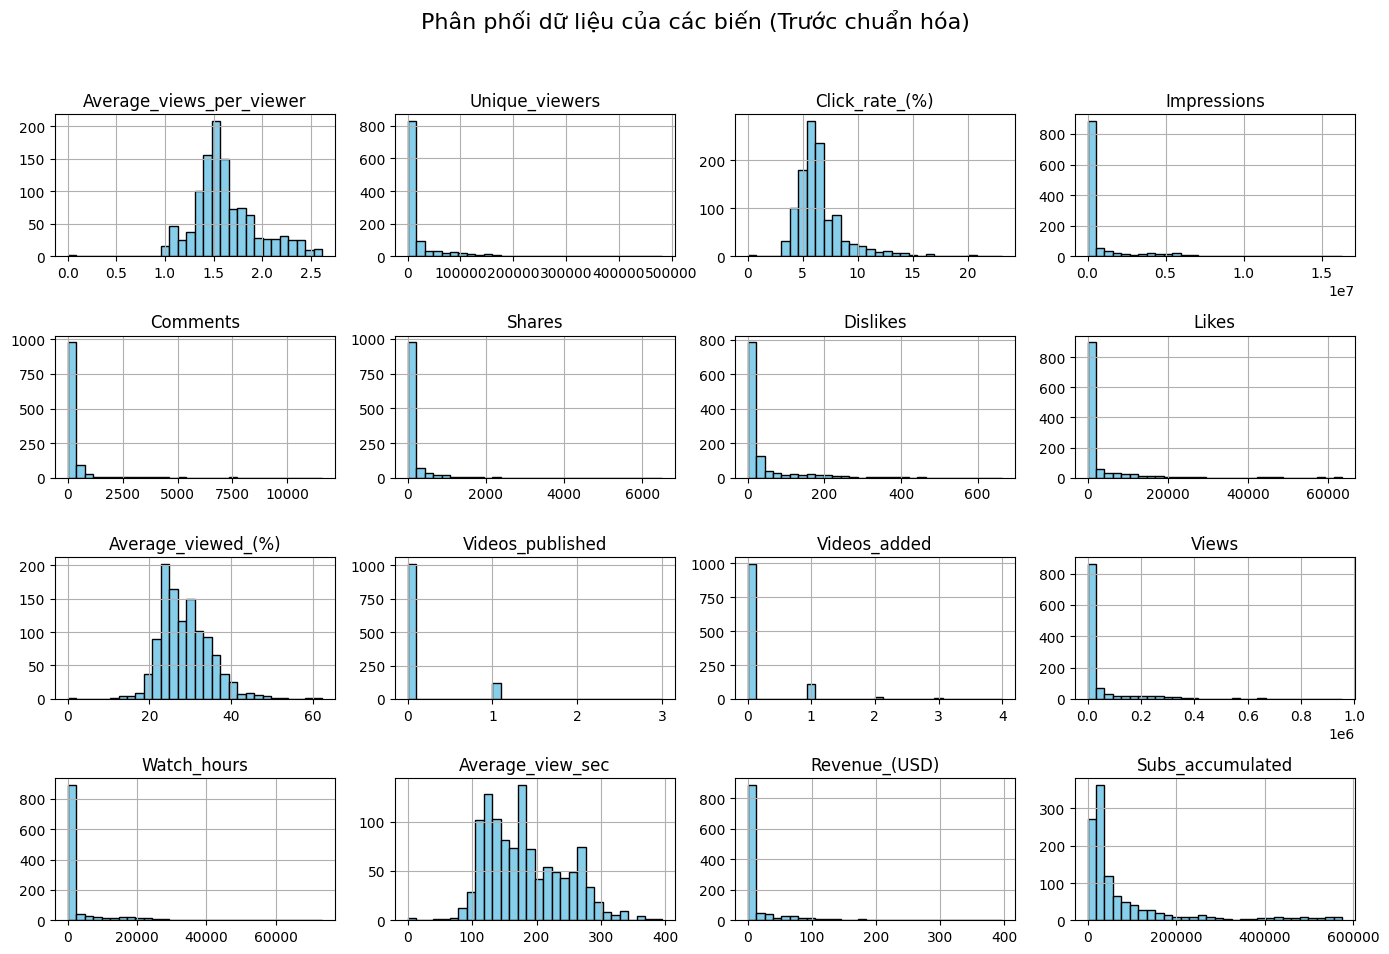

In [9]:
if df is not None:
    print("\n🔹 Trực quan hóa phân phối (Histogram):")
    plt.figure(figsize=(12,8))
    df.hist(bins=30, figsize=(14,10), color='skyblue', edgecolor='black')
    plt.suptitle("Phân phối dữ liệu của các biến (Trước chuẩn hóa)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



🔹 Trực quan hóa ngoại lai (Boxplot):


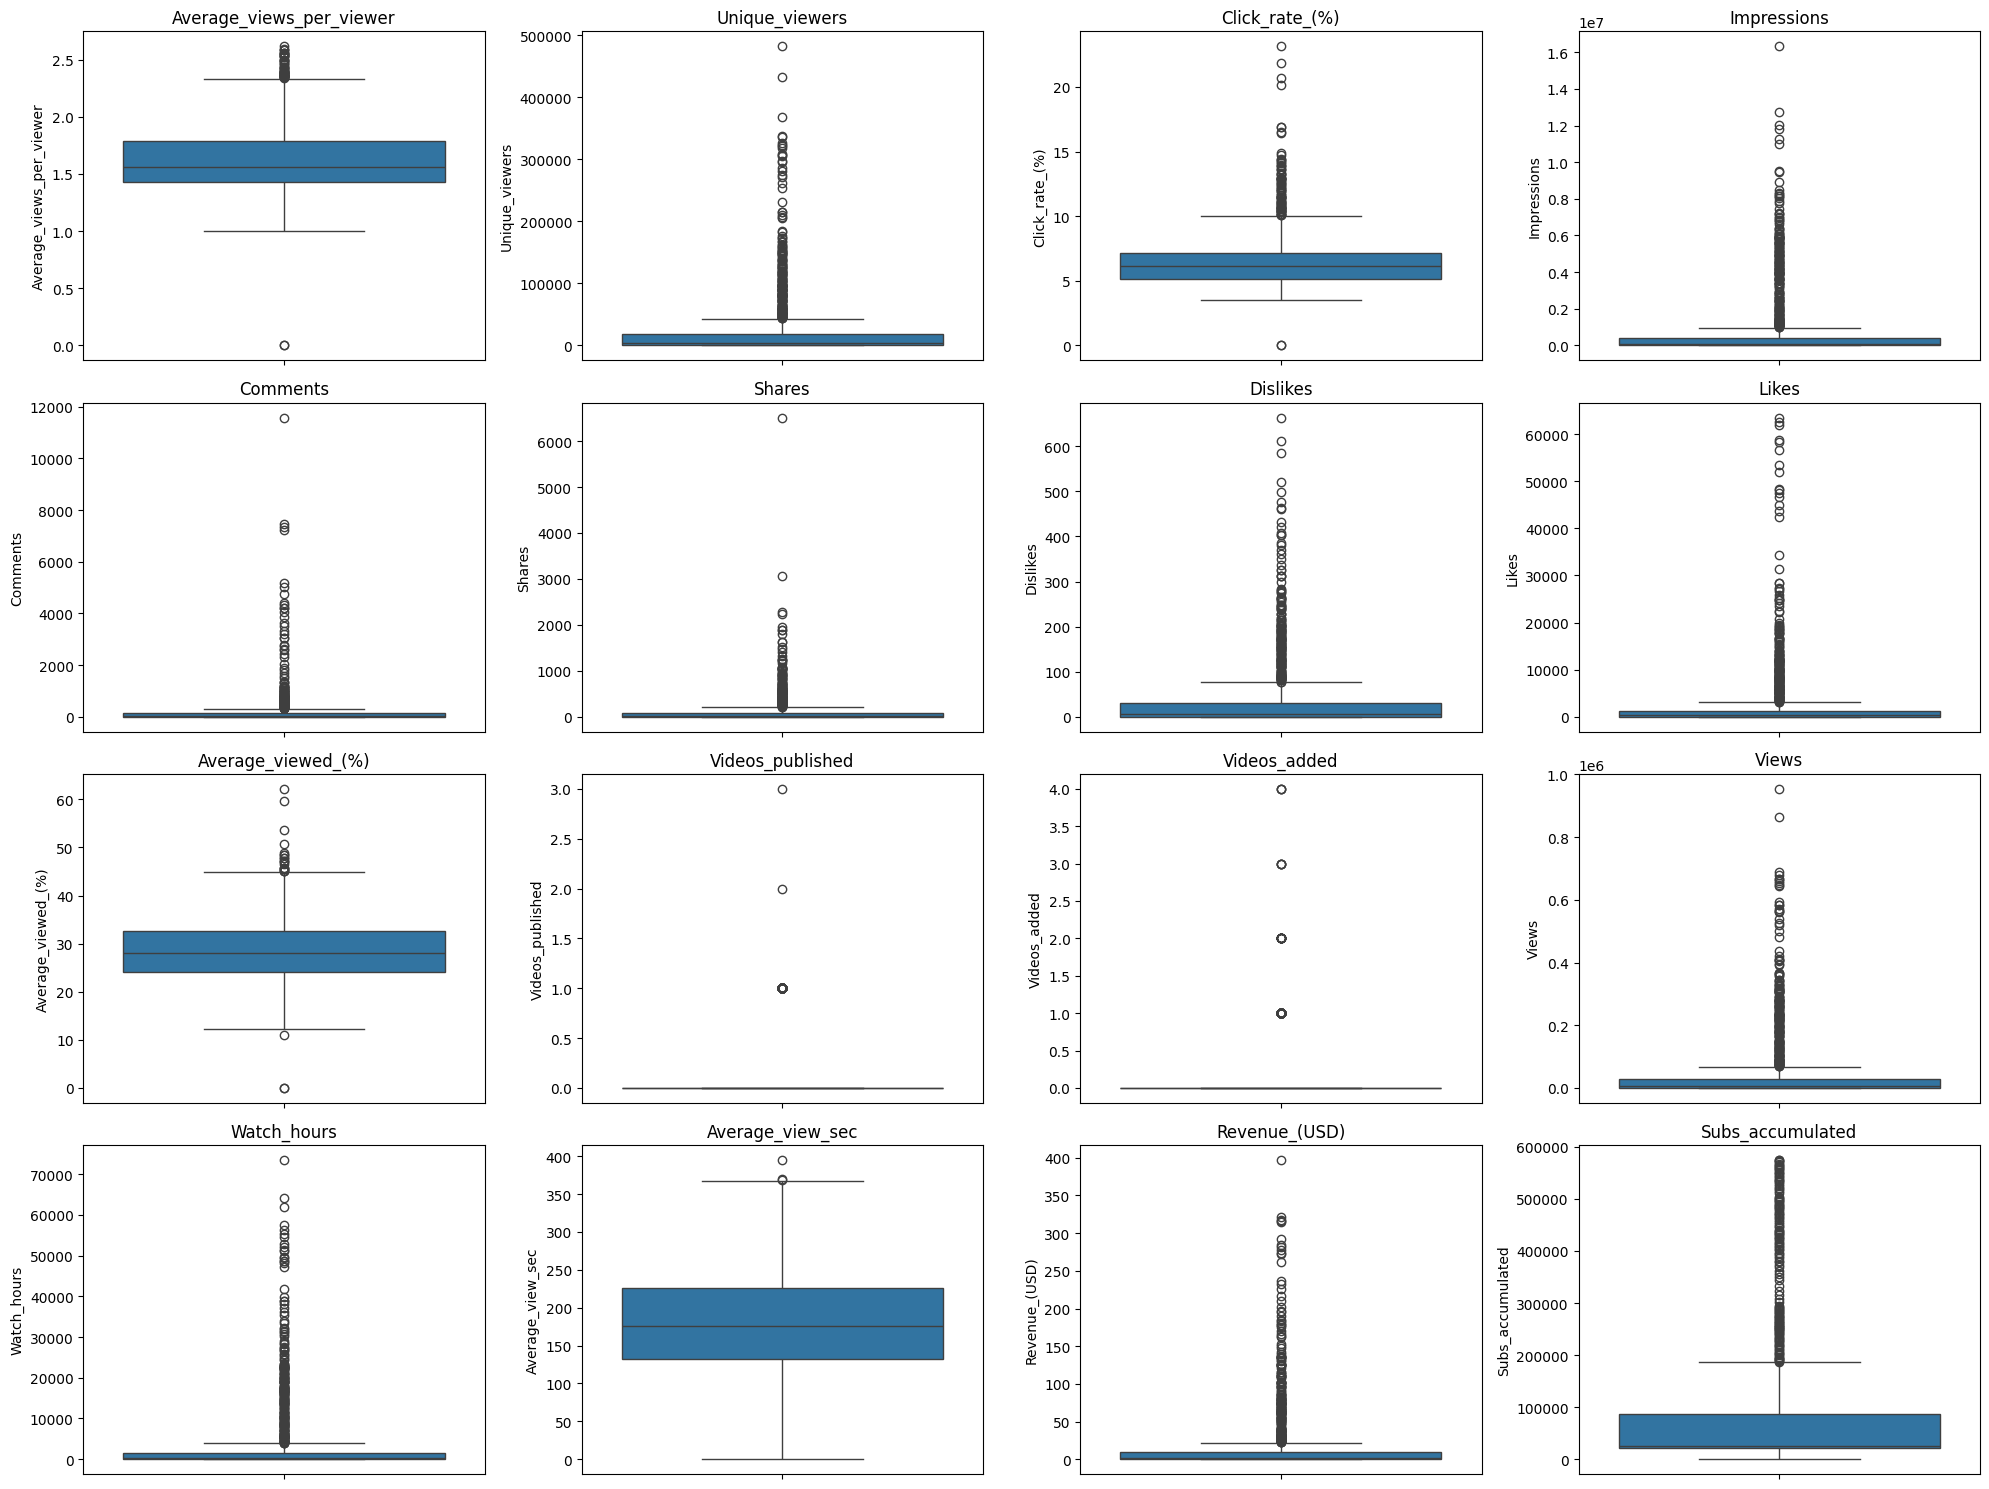

>>> KẾT LUẬN: Các biểu đồ hộp bị 'nén' -> Khẳng định có ngoại lai CỰC LỚN.


In [10]:
if df is not None:
    print("\n🔹 Trực quan hóa ngoại lai (Boxplot):")
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

    plt.figure(figsize=(20, 15))
    num_cols = len(numerical_cols)
    cols_per_row = 4
    num_rows = (num_cols + cols_per_row - 1) // cols_per_row 

    for i, col in enumerate(numerical_cols):
        plt.subplot(num_rows, cols_per_row, i + 1)
        sns.boxplot(y=df[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()
    print(">>> KẾT LUẬN: Các biểu đồ hộp bị 'nén' -> Khẳng định có ngoại lai CỰC LỚN.")


🔹 Ma trận tương quan (Heatmap):


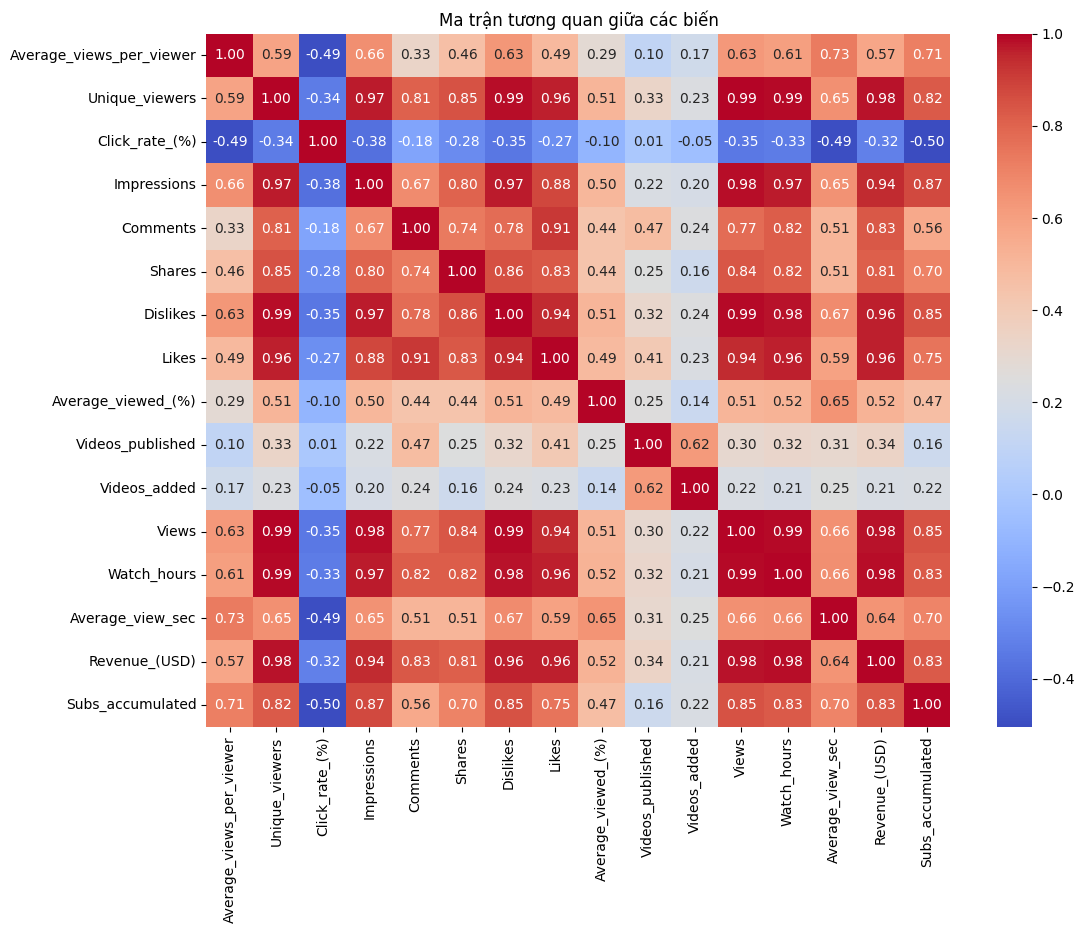

>>> KẾT LUẬN: Đa cộng tuyến cao (ví dụ: Views, Watch_hours, Impressions).


In [11]:
if df is not None:
    print("\n🔹 Ma trận tương quan (Heatmap):")
    plt.figure(figsize=(12,9))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Ma trận tương quan giữa các biến")
    plt.show()
    print(">>> KẾT LUẬN: Đa cộng tuyến cao (ví dụ: Views, Watch_hours, Impressions).")

In [12]:
if df is not None:
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    print("\n🔹 Dữ liệu sau khi chuẩn hóa (RobustScaler):")
    display(X_scaled_df.describe().T.round(5))
else:
    print("LỖI: 'df' rỗng.")


🔹 Dữ liệu sau khi chuẩn hóa (RobustScaler):


,count,mean,std,min,25%,50%,75%,max
Average_views_per_viewer,1135.0,0.18684,0.91110,-4.26387,-0.35704,0.0,0.64296,2.90369
Unique_viewers,1135.0,1.22561,3.15956,-0.23340,-0.20719,0.0,0.79281,27.54461
Click_rate_(%),1135.0,0.22933,1.15204,-3.10941,-0.48346,0.0,0.51654,8.66667
Impressions,1135.0,1.96410,4.83314,-0.17694,-0.15519,0.0,0.84481,41.86182
Comments,1135.0,1.55181,5.84228,-0.22222,-0.20635,0.0,0.79365,91.69841
Shares,1135.0,1.19185,3.94790,-0.26036,-0.23669,0.0,0.76331,76.81657
Dislikes,1135.0,1.09150,2.66922,-0.19672,-0.19672,0.0,0.80328,21.57377
Likes,1135.0,2.05653,6.07008,-0.20667,-0.19487,0.0,0.80513,51.49634
Average_viewed_(%),1135.0,0.07813,0.74924,-3.36571,-0.46523,0.0,0.53477,4.09113
Videos_published,1135.0,0.11013,0.32426,0.00000,0.00000,0.0,0.00000,3.00000


In [13]:
if df is not None:
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled) # Chạy PCA trên dữ liệu đã RobustScale

    # Tạo DataFrame PCA
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    print("\n🔹 Thống kê các Thành phần chính (Kịch bản Robust):")
    display(X_pca_df.describe().T.round(5))
else:
    print("LỖI: 'df' rỗng.")


🔹 Thống kê các Thành phần chính (Kịch bản Robust):


,count,mean,std,min,25%,50%,75%,max
PC1,1135.0,0.0,12.82124,-5.65093,-5.36039,-4.75214,-2.44007,102.48682
PC2,1135.0,0.0,3.56950,-19.94625,0.23549,0.54972,0.64897,54.86273
PC3,1135.0,0.0,2.05203,-9.98581,-0.00586,0.04244,0.11711,51.33662
PC4,1135.0,-0.0,1.26450,-9.77804,-0.71999,-0.07937,0.49863,7.84291
PC5,1135.0,-0.0,0.93519,-12.62612,-0.24766,0.15611,0.33738,12.65968
PC6,1135.0,0.0,0.78966,-6.78143,-0.36024,-0.09753,0.21080,5.50849
PC7,1135.0,-0.0,0.66873,-5.70935,-0.42662,-0.04346,0.41217,3.40065
PC8,1135.0,-0.0,0.60714,-5.52816,-0.36602,-0.02289,0.38343,2.23414
PC9,1135.0,0.0,0.53271,-3.62426,-0.20284,-0.07349,0.04732,5.68759
PC10,1135.0,-0.0,0.38598,-2.39641,-0.12946,-0.01241,0.06523,3.53602



🔹 Phương sai giải thích (Kịch bản Robust):
PC1: 88.40% | Tổng tích lũy: 88.40%
PC2: 6.85% | Tổng tích lũy: 95.25%
PC3: 2.26% | Tổng tích lũy: 97.51%
PC4: 0.86% | Tổng tích lũy: 98.37%
PC5: 0.47% | Tổng tích lũy: 98.84%
PC6: 0.34% | Tổng tích lũy: 99.18%
PC7: 0.24% | Tổng tích lũy: 99.42%
PC8: 0.20% | Tổng tích lũy: 99.62%
PC9: 0.15% | Tổng tích lũy: 99.77%
PC10: 0.08% | Tổng tích lũy: 99.85%
PC11: 0.06% | Tổng tích lũy: 99.91%
PC12: 0.04% | Tổng tích lũy: 99.95%
PC13: 0.02% | Tổng tích lũy: 99.98%
PC14: 0.02% | Tổng tích lũy: 99.99%
PC15: 0.01% | Tổng tích lũy: 100.00%


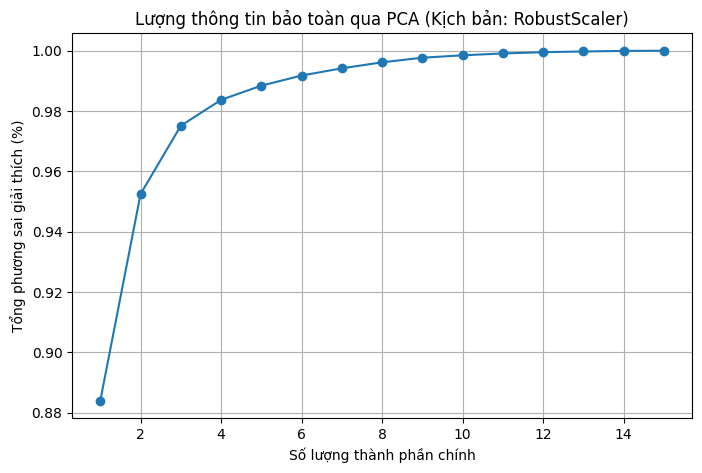

In [14]:
if df is not None:
    print("\n🔹 Phương sai giải thích (Kịch bản Robust):")
    explained_var_ratio = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var_ratio)

    for i, var in enumerate(explained_var_ratio):
        print(f"PC{i+1}: {var*100:.2f}% | Tổng tích lũy: {cumulative_var[i]*100:.2f}%")

    # Biểu đồ trực quan
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
    plt.xlabel('Số lượng thành phần chính')
    plt.ylabel('Tổng phương sai giải thích (%)')
    plt.title('Lượng thông tin bảo toàn qua PCA (Kịch bản: RobustScaler)')
    plt.grid(True)
    plt.show()
else:
    print("LỖI: 'df' rỗng.")


🔹 Trực quan hóa PC theo cặp (Kịch bản Robust)


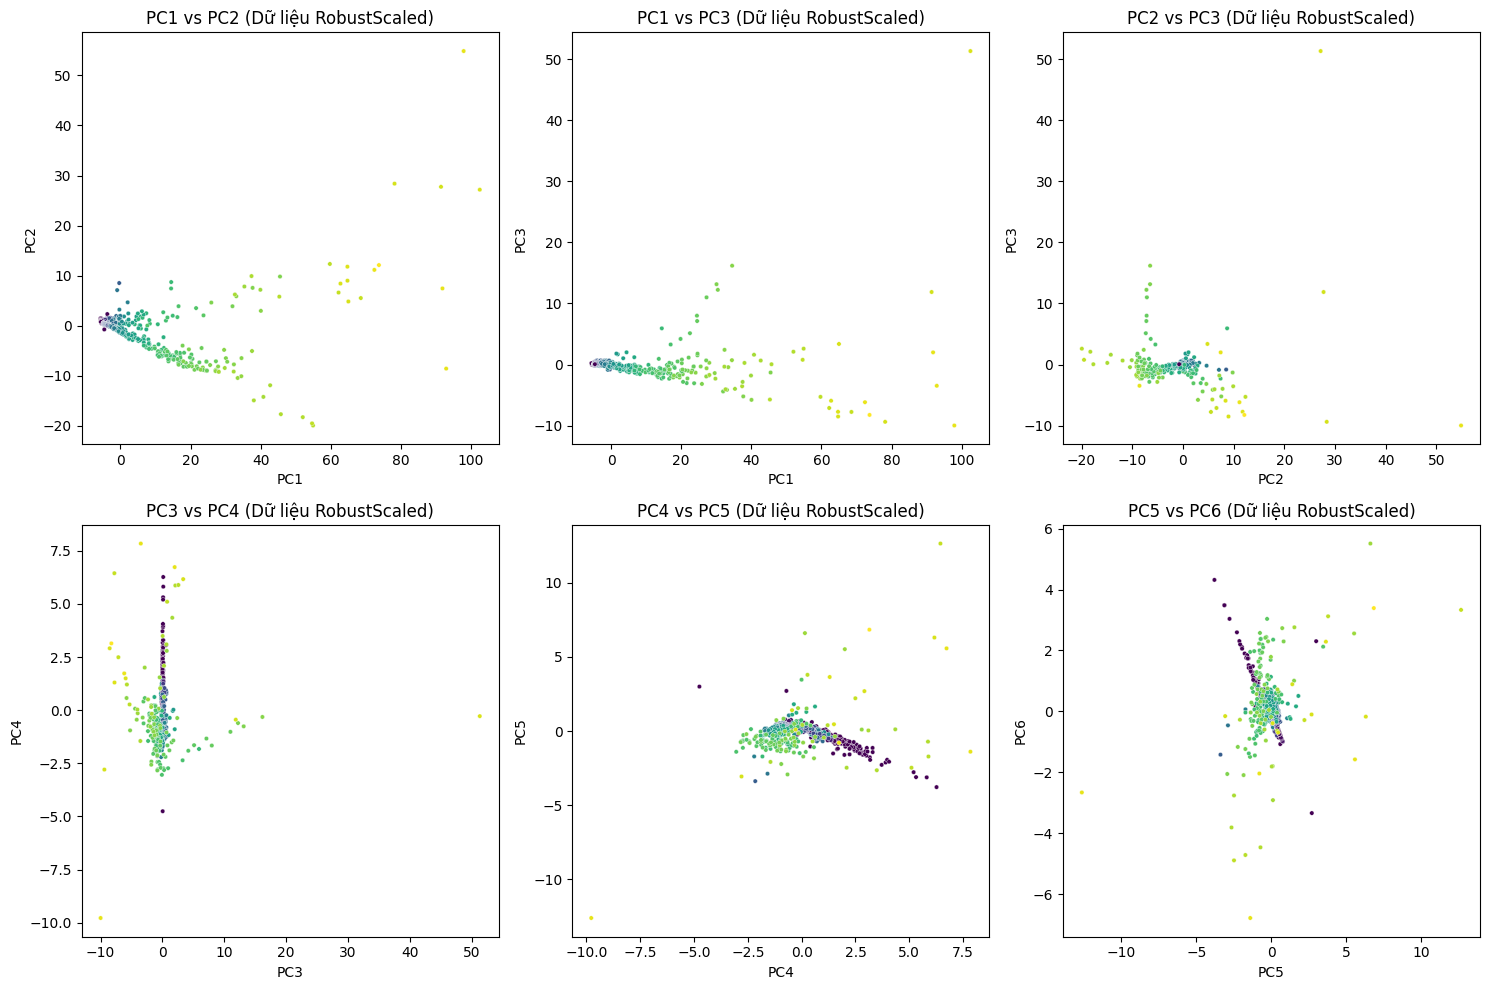

In [15]:
if df is not None:
    print("\n🔹 Trực quan hóa PC theo cặp (Kịch bản Robust)")
    pca_n = PCA(n_components=6)
    X_pca_n = pca_n.fit_transform(X_scaled)

    # <<< SỬA LỖI: DÙNG LOG1P CHO MÀU SẮC (HUE) >>>
    # Biến y (Revenue) bị lệch nặng, dùng y_gốc làm màu sẽ cho toàn màu tím.
    # Dùng log1p(y) "nén" thang màu lại giúp biểu đồ có dải màu (gradient) đẹp.
    y_color = np.log1p(y) 

    plt.figure(figsize=(15,10))
    pairs = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5)]

    for i, (a,b) in enumerate(pairs[:6]):
        plt.subplot(2,3,i+1)
        sns.scatterplot(x=X_pca_n[:,a], y=X_pca_n[:,b], hue=y_color, palette='viridis', legend=False, s=10) # s=10 cho điểm nhỏ hơn
        plt.xlabel(f'PC{a+1}')
        plt.ylabel(f'PC{b+1}')
        plt.title(f'PC{a+1} vs PC{b+1} (Dữ liệu RobustScaled)')
    plt.tight_layout()
    plt.show()
else:
    print("LỖI: 'df' rỗng.")


🔹 Tương quan PC (Kịch bản Robust) với Doanh thu:


Revenue_(USD)    1.000000
PC1              0.981039
PC6              0.032412
PC5              0.021007
PC4              0.016598
PC2             -0.065911
PC3             -0.082073
Name: Revenue_(USD), dtype: float64

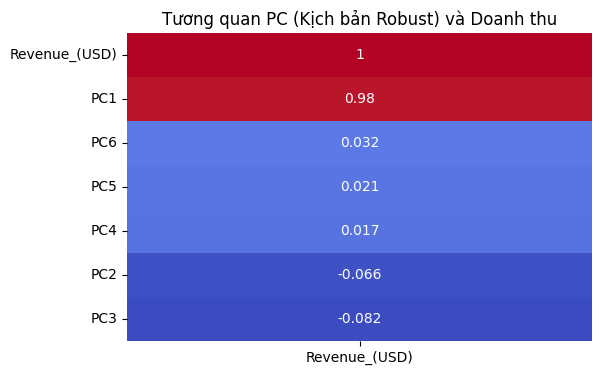

In [16]:
if df is not None:
    print("\n🔹 Tương quan PC (Kịch bản Robust) với Doanh thu:")
    pca_df = pd.DataFrame(X_pca_n, columns=[f'PC{i+1}' for i in range(6)])
    pca_df[target] = y.values # y gốc (chưa log)

    corr = pca_df.corr()[target].sort_values(ascending=False)
    display(corr)

    # Biểu đồ heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm', cbar=False)
    plt.title('Tương quan PC (Kịch bản Robust) và Doanh thu')
    plt.show()
else:
    print("LỖI: 'df' rỗng.")